In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
camera_calibration_folder = 'camera_cal'
files = os.listdir(camera_calibration_folder)

In [3]:
cal_cam_img_path = []
cal_cam_img = []
for f in files:
    fpath = os.path.join(camera_calibration_folder, f)
    if(os.path.isfile(fpath)):
        cal_cam_img_path.append(fpath)
        cal_cam_img.append(cv2.imread(fpath))

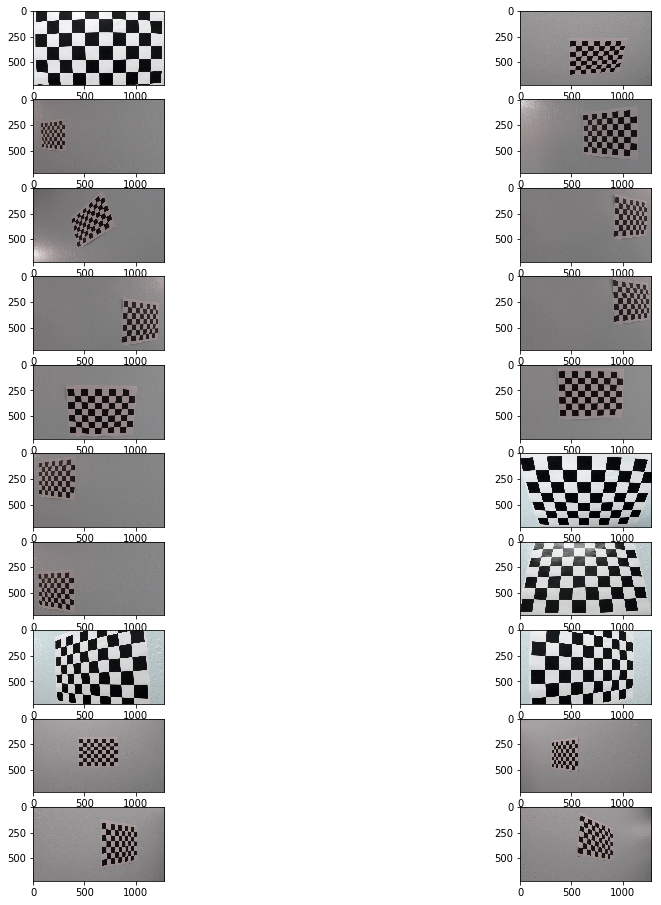

In [174]:
def show_allImg(images, col=4):
    rows = len(images)//col
    fig = plt.figure(figsize=(16, 16))
    for i in range(len(images)):
        fig.add_subplot(rows, col, i+1)
        plt.imshow(images[i])

show_allImg(cal_cam_img, col=2)

In [5]:
def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
def rgb2gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
def bgr2gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [6]:
NX = 9
NY = 6
offset = 100
X_size = cal_cam_img[0].shape[1]
Y_size = cal_cam_img[0].shape[0]

In [35]:
def finddrawChessBoardCorners(img, nx, ny, isGray=True):
    if(isGray == False):
        img = bgr2gray(img)
    ret, corners = cv2.findChessboardCorners(img, (nx, ny), None)
    if(ret == True):
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        return img
    return None

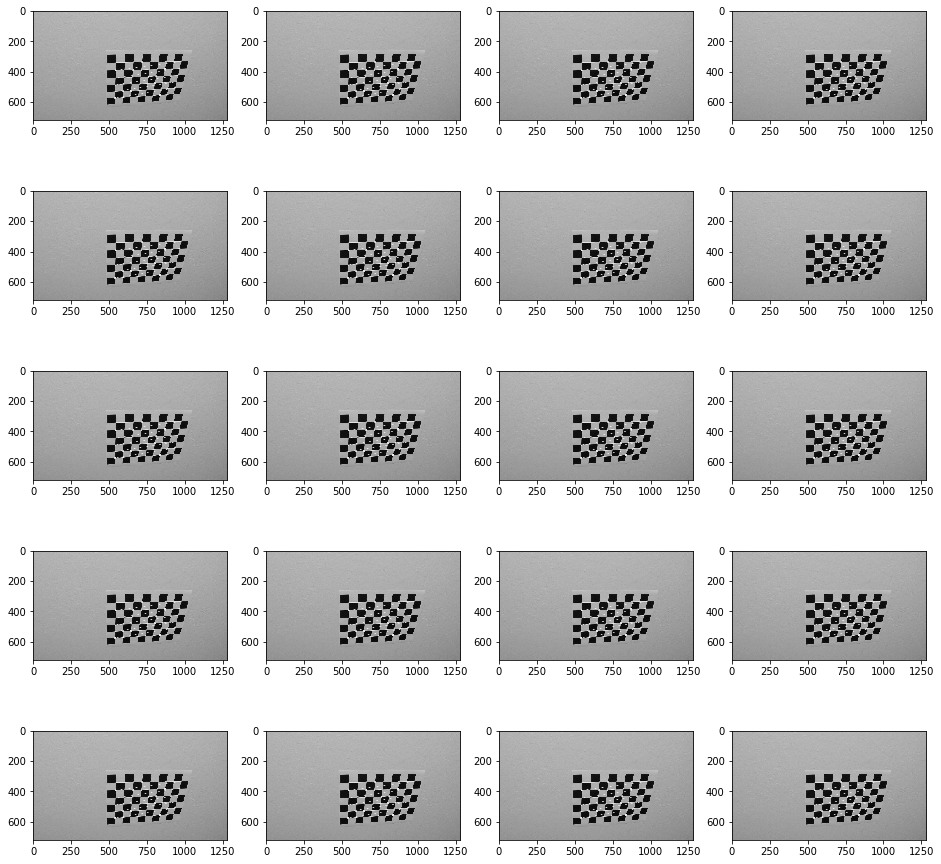

In [43]:
fig = plt.figure(figsize=(16, 16))
for i in range(len(cal_cam_img)):
    img = finddrawChessBoardCorners(cal_cam_img[1], NX, NY, False)
    fig.add_subplot(5, 4, i+1)
    plt.imshow(img, cmap='gray')

In [38]:
imgPoints = []
objPoints = []
objP = np.zeros((NX*NY, 3), np.float32)
objP[:,:2] = np.mgrid[0:NX,0:NY].T.reshape(-1, 2)

for img in cal_cam_img:
    gray = bgr2gray(img)
    ret, corners = cv2.findChessboardCorners(gray, (NX, NY), None)
    
    if(ret):
        imgPoints.append(corners)
        objPoints.append(objP)
#         img = cv2.drawChessboaxdrrdCorners(img, (NX, NY), corners, ret)


In [39]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, (X_size, Y_size), None, None)

In [40]:
straing_img = plt.imread('test_images/straight_lines1.jpg')

In [41]:
def undist(img):
    return cv2.undistort(img, mtx, dist, None, mtx)
straing_img_undist = cv2.undistort(straing_img, mtx, dist, None, mtx)

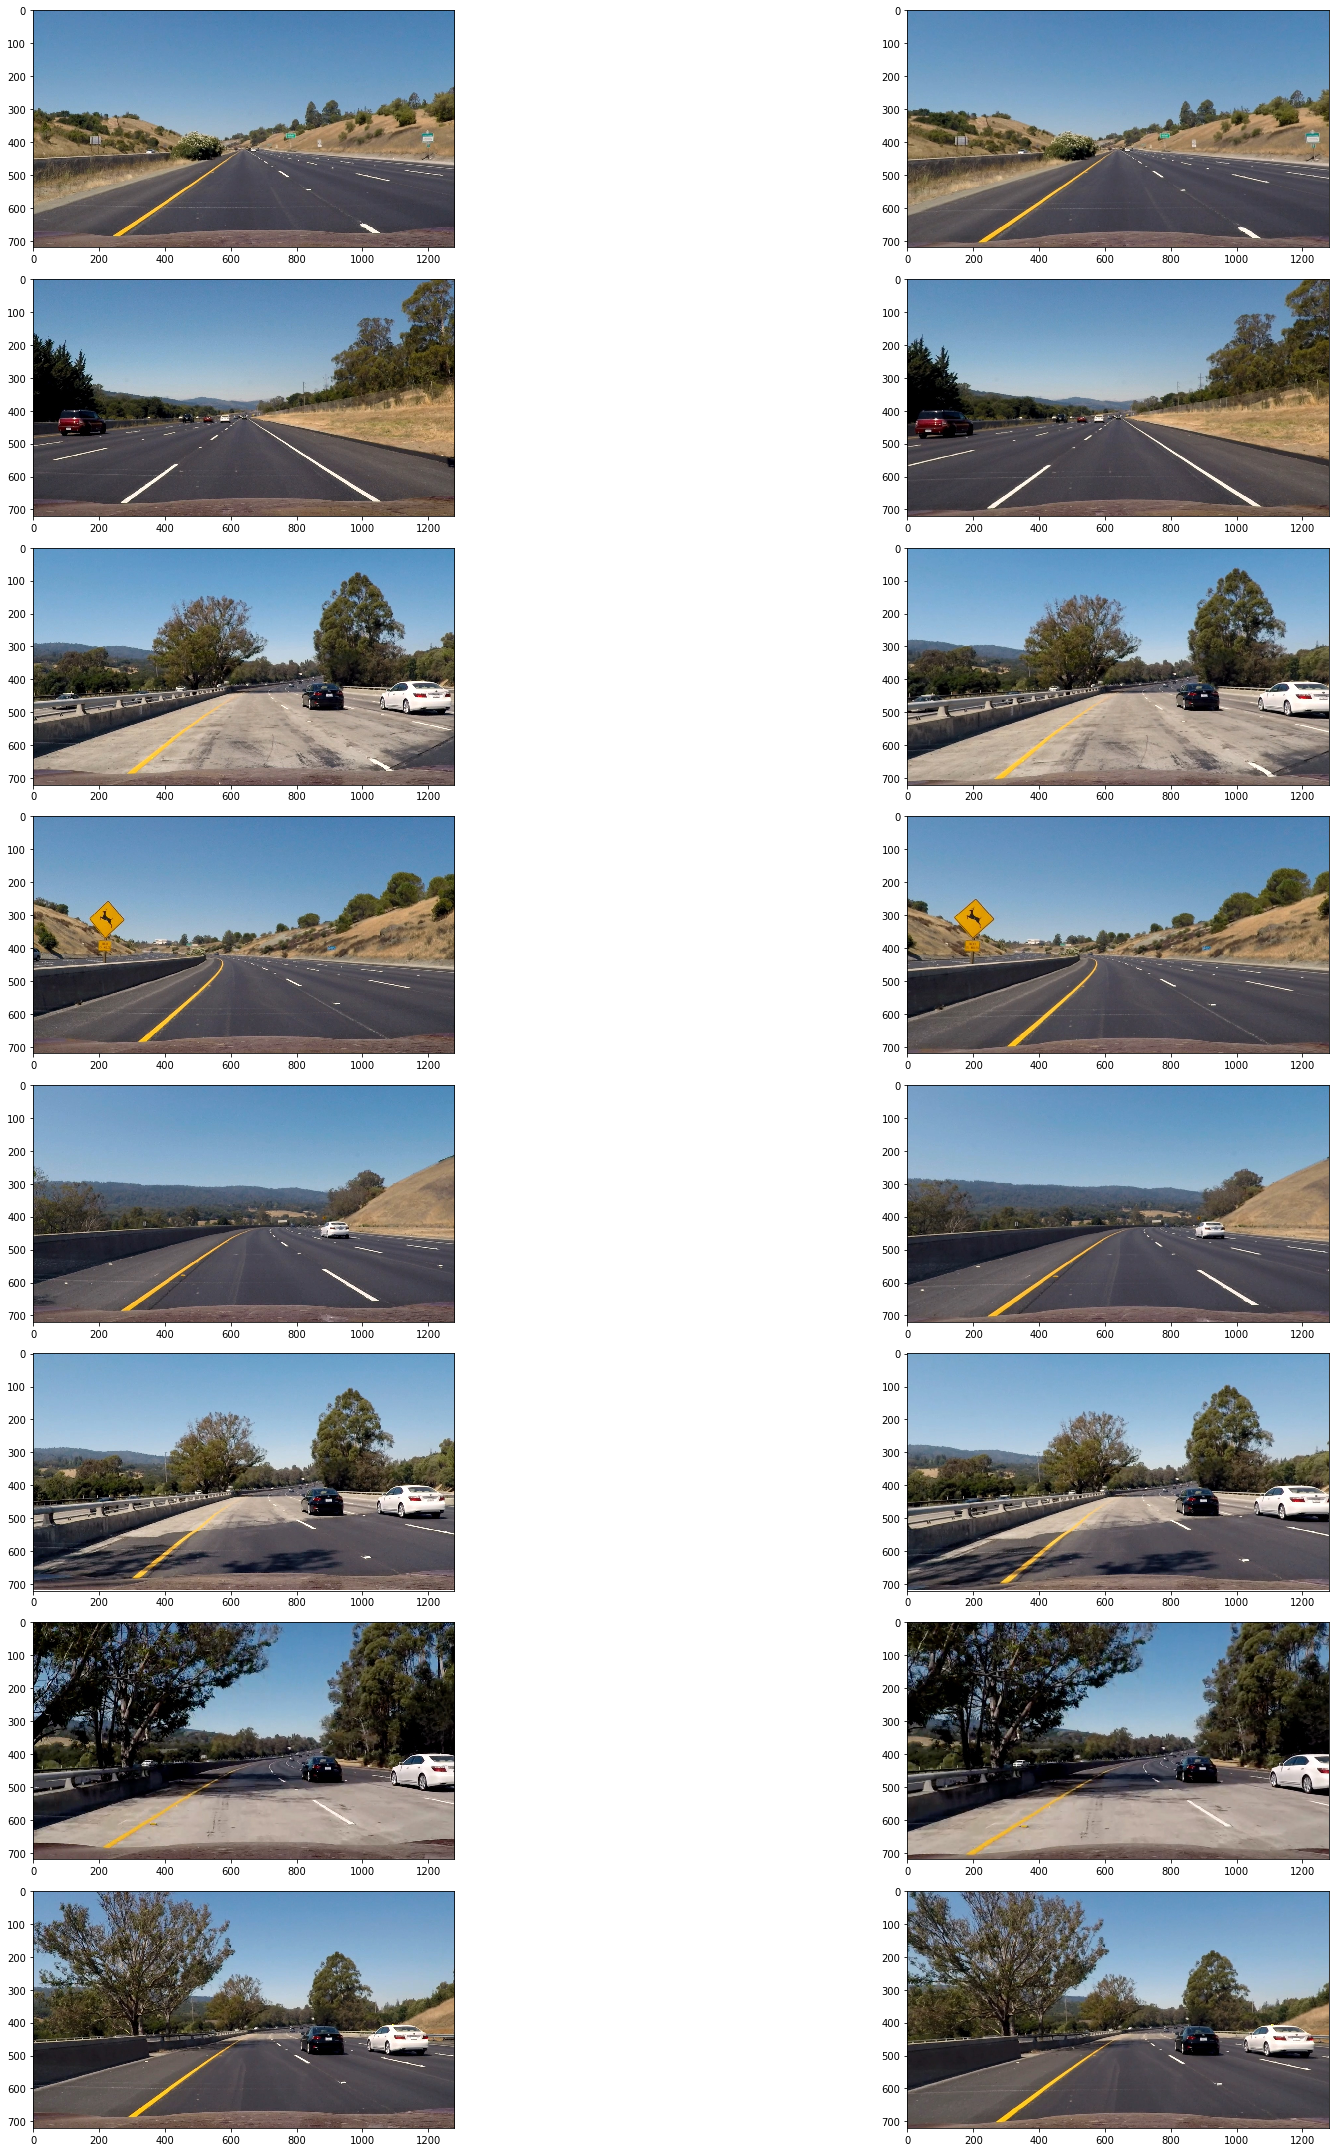

In [107]:
test_images_folder = 'test_images'
test_images_path = os.listdir(test_images_folder)
test_images = []
test_images_undist = []
fig = plt.figure(figsize=(30,30))
j = 1
for i in range(len(test_images_path)):
    path = os.path.join(test_images_folder, test_images_path[i])
    test_images.append(plt.imread(path))
    
    fig.add_subplot(8, 2, j)
    fig.subplots_adjust(wspace = 0.5)
    plt.imshow(test_images[i])
    
    j+=1
    img = undist(test_images[i])
    test_images_undist.append(img)
    fig.add_subplot(8, 2, j)
    fig.subplots_adjust(wspace = 0.5)
    plt.imshow(img)
    j+=1
    plt.tight_layout()

In [101]:
ROI_PTS = np.array([[170,702],[580, 440],[700, 440], [1200, 702]], np.int32)
ROI_PTS = ROI_PTS.reshape((-1,1,2))

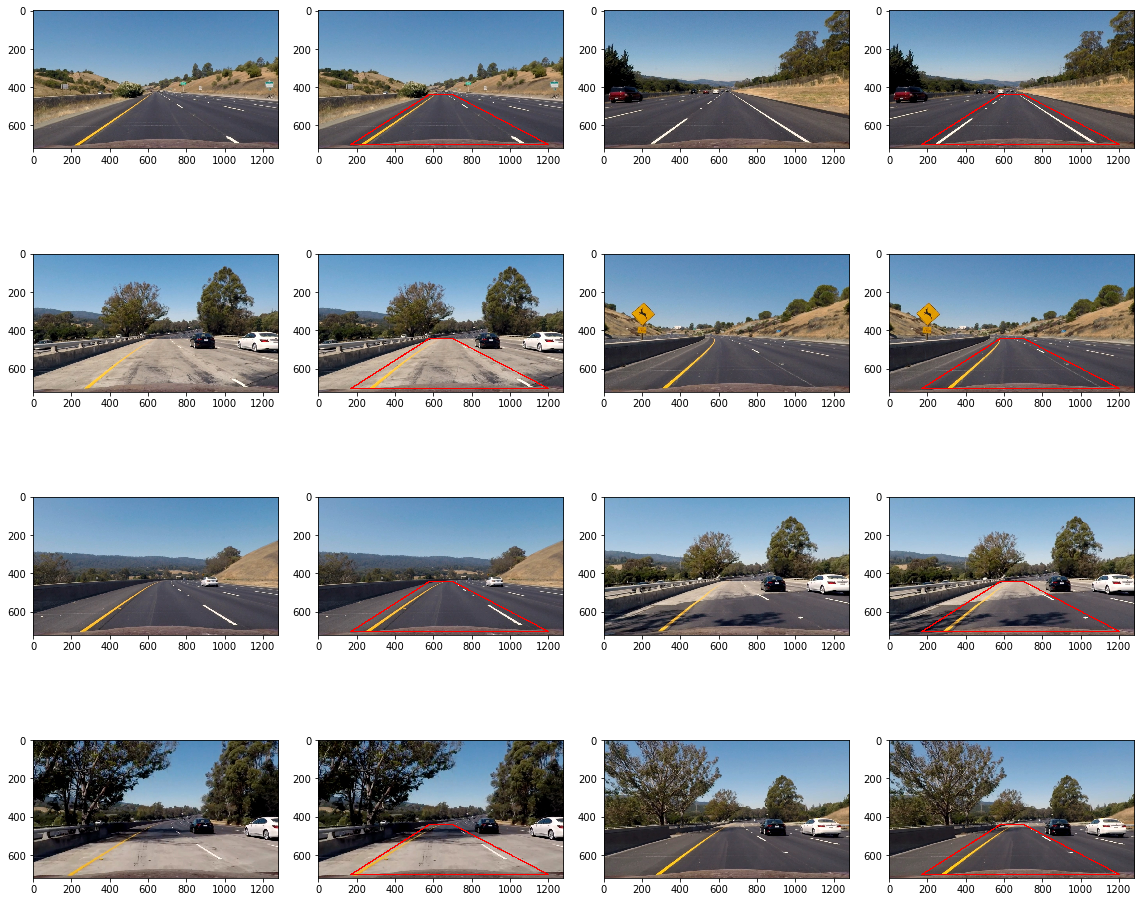

In [103]:
j = 1
fig = plt.figure(figsize = (16,16))
for img in test_images_undist:
    roi_img = np.copy(img)
    
    fig.add_subplot(4, 4, j)
    plt.imshow(img)
    j+=1
    fig.add_subplot(4, 4, j)
    poly_undist = cv2.polylines(roi_img, [ROI_PTS], True,(255,0,0),5)
    plt.imshow(poly_undist)
    j+=1
    plt.tight_layout()

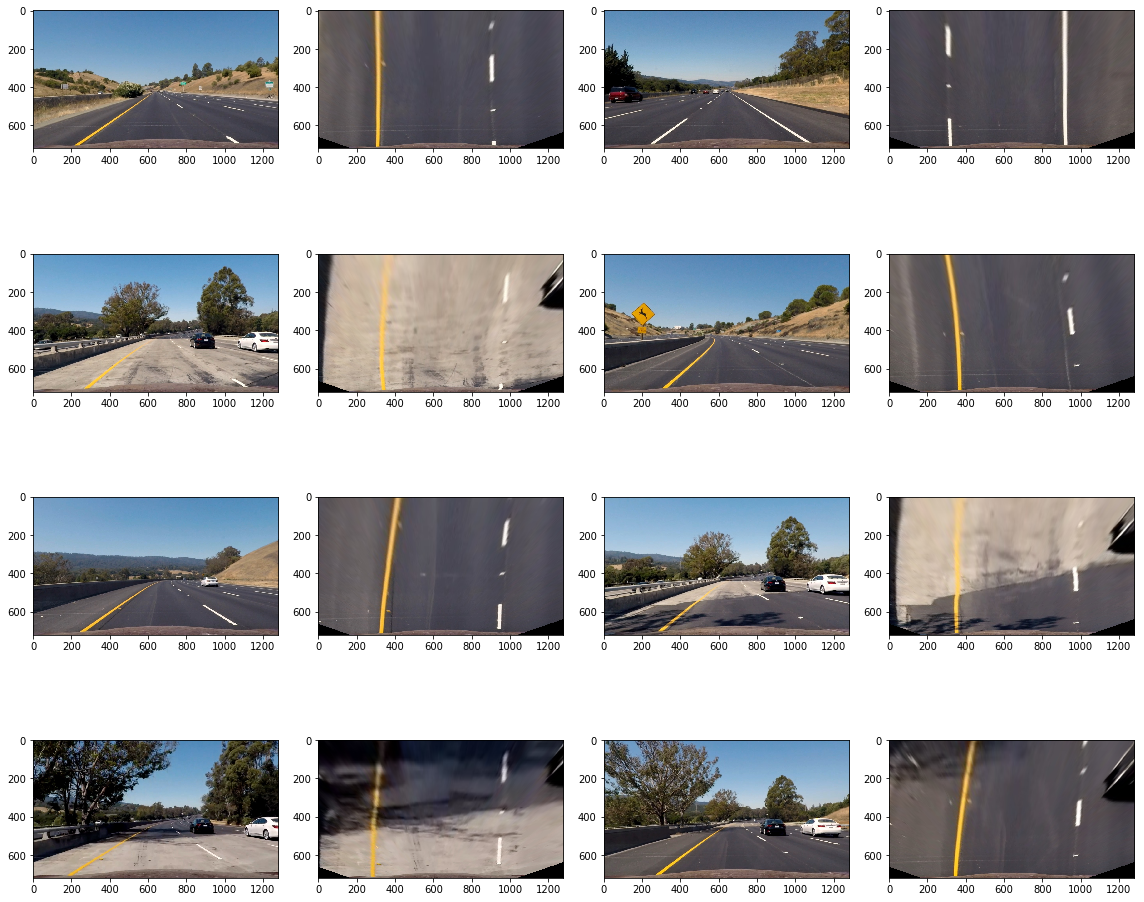

In [496]:
src = np.array([[220,720],[570, 470],[722, 470], [1110, 720]], np.float32)
src = src.reshape((-1,1,2))
dst = np.array([[320,720],[320, 1],[920, 1], [920, 720]], np.float32)
dst = dst.reshape((-1,1,2))
M = cv2.getPerspectiveTransform(src, dst)

j = 1
fig = plt.figure(figsize = (16,16))
test_images_warped = []
for img in test_images_undist:
    roi_img = np.copy(img)
    
    fig.add_subplot(4, 4, j)
    plt.imshow(img)
    j+=1
    fig.add_subplot(4, 4, j)
    warped = cv2.warpPerspective(img, M, (X_size, Y_size), flags=cv2.INTER_LINEAR)
    test_images_warped.append(warped)
    plt.imshow(warped)
    j+=1
    plt.tight_layout()


In [497]:
def sobel(img, orientation = 'x', kernel_size=3):
    if(orientation == 'x'):
        return np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = kernel_size))
    else:
        return np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = kernel_size))
    
def mag_sobel(img, kernel_size = 3, thresh=[20,100]):
    sobelx = sobel(img, 'x', kernel_size)
    sobely = sobel(img, 'y', kernel_size)
    mag = np.sqrt(np.square(sobelx) + np.square(sobely))
    binary_output_mag = np.zeros_like(gray)
    scaled_mag = np.uint8(255*mag/np.max(mag))
    binary_output_mag[(scaled_mag>=thresh[0]) & (scaled_mag<=thresh[1])] = 1
    return binary_output_mag

def grad_sobel(img, kernel_size = 7, thers=[20,120]):
    sobelx = sobel(img, 'x', kernel_size)
    sobely = sobel(img, 'y', kernel_size)
    arct= np.arctan2(sobely, sobelx)
    
    binary_output_arct = np.zeros_like(gray)
    scaled_arct = np.uint8(255*arct/np.max(arct))
    
    binary_output_arct[(scaled_arct>=thresh[0]) & (scaled_arct<=thresh[1])] = 1
    return binary_output_arct

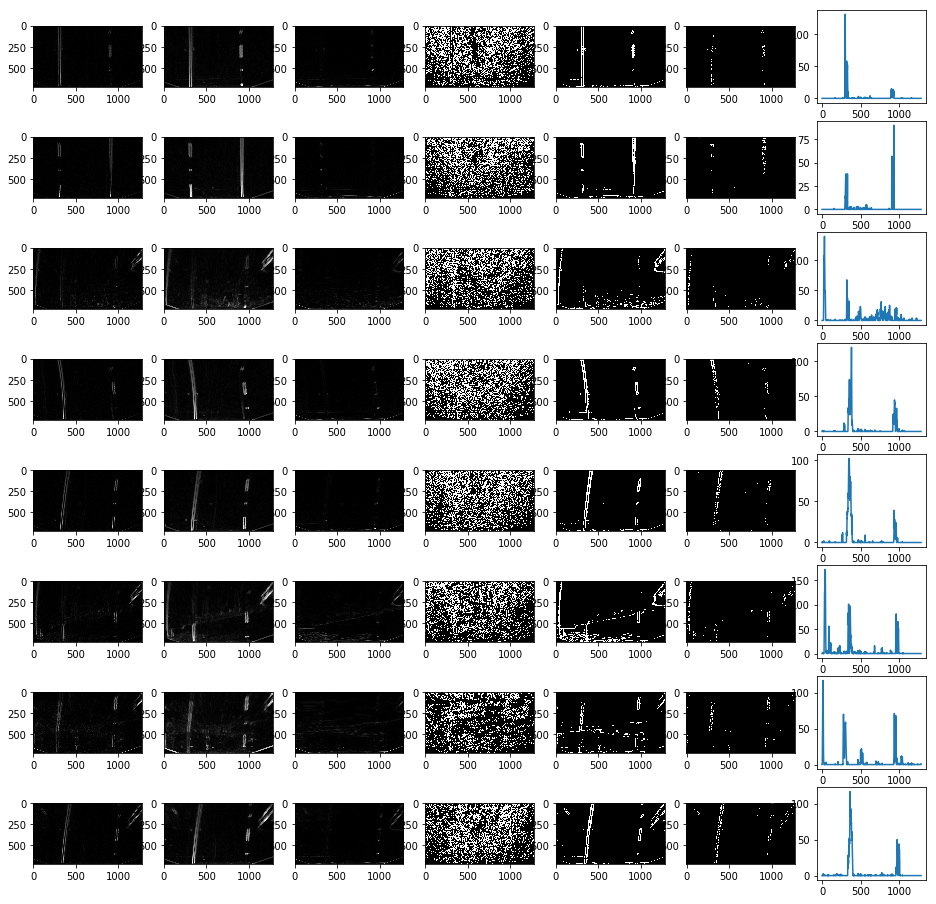

In [498]:
def calibrationMap(images, code, channel, kernel_size = 7, thresh = [50,120]):
    fig, axis = plt.subplots(8, 7, figsize=(16,16))

    for ind, img in enumerate(images):
        gray = cv2.cvtColor(img, code)[:,:,channel]
        #axis[ind, 0].imshow(img)

        sobelx = sobel(gray, 'x', kernel_size)
        axis[ind, 0].imshow(sobelx, cmap='gray')
        kernel = np.ones((5,5),np.uint8)
        sobelx = cv2.dilate(sobelx, kernel, iterations = 2)
        axis[ind, 1].imshow(sobelx, cmap='gray')
        
        sobely = sobel(gray, 'y', kernel_size)
        axis[ind, 2].imshow(sobely, cmap='gray')

        binary_output_arct = grad_sobel(gray, kernel_size, thresh)
        axis[ind, 3].imshow(binary_output_arct, cmap='gray')

        binary_output_mag = mag_sobel(gray, kernel_size, thresh)
        axis[ind, 4].imshow(binary_output_mag, cmap='gray')
        
        combined = np.zeros_like(binary_output_mag)
        combined[((sobelx == 1)) | ((binary_output_arct == 1) & (binary_output_mag == 1))] = 1
        axis[ind, 5].imshow(combined, cmap='gray')
        
        histogram = np.sum(combined[combined.shape[0]//2:,:], axis=0)
        axis[ind, 6].plot(histogram)
        
calibrationMap(test_images_warped, cv2.COLOR_RGB2HSV, 2, kernel_size = 7, thresh = [20,120])

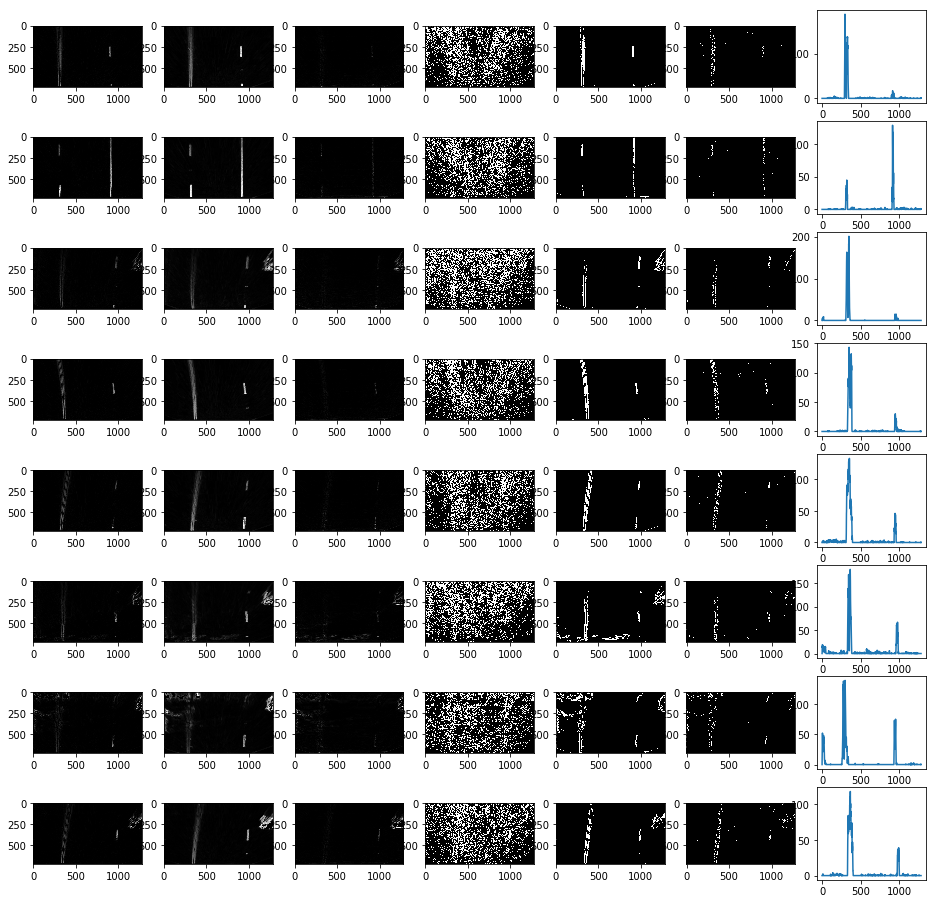

In [499]:
calibrationMap(test_images_warped, cv2.COLOR_RGB2HLS, 2, kernel_size = 7, thresh = [20,120])

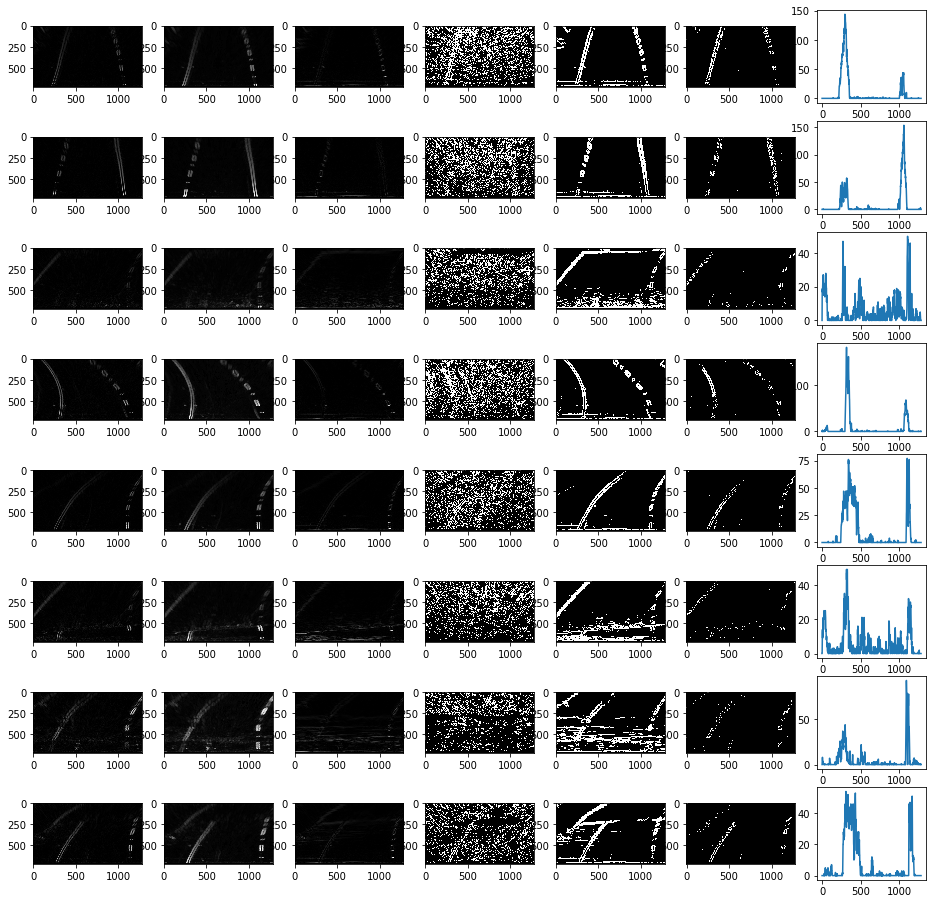

In [274]:
calibrationMap(test_images_warped, cv2.COLOR_RGB2HLS, 1, kernel_size = 9, thresh = [10,180])

# Lane Sliding Window

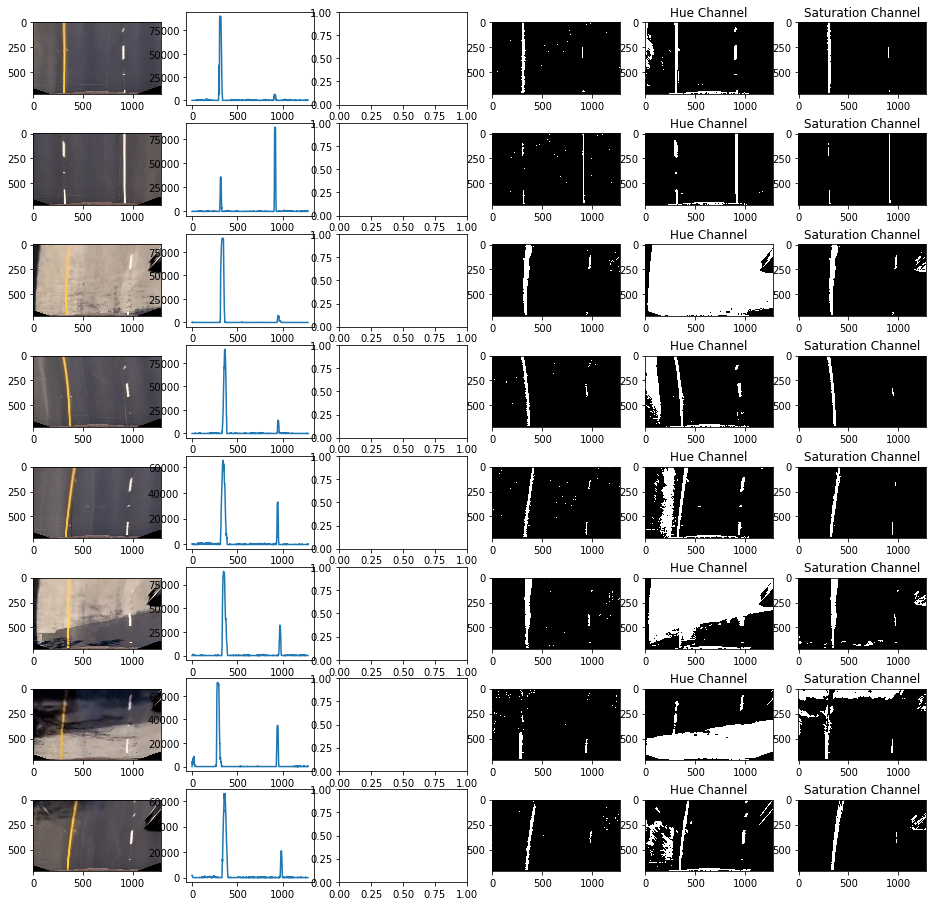

In [541]:
grayed_lanes = []
def calibrationMapAll(images, code, channel, kernel_size = 7, thresh = [20,120]):
    fig, axis = plt.subplots(8, 6, figsize=(16,16))

    for ind, img in enumerate(images):
        imgYellow = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        imgYcr = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

        gray = cv2.cvtColor(img, code)[:,:,channel]
        #axis[ind, 0].imshow(img)

        sobelx = sobel(gray, 'x', kernel_size)
        axis[ind, 0].imshow(img)
        kernel = np.ones((5,5),np.uint8)
        sobelx = cv2.dilate(sobelx, kernel, iterations = 2)
#         axis[ind, 1].imshow(sobelx, cmap='gray')
        
        sobely = sobel(gray, 'y', kernel_size)
#         axis[ind, 2].imshow(sobely, cmap='gray')
# 
        binary_output_arct = grad_sobel(gray, kernel_size, thresh)
        #axis[ind, 3].imshow(binary_output_arct, cmap='gray')

        binary_output_mag = mag_sobel(gray, kernel_size, thresh)
#         axis[ind, 3].imshow(binary_output_mag, cmap='gray')
        lower_blue = np.array([0,100,0])
        upper_blue = np.array([255,255,255])
        hueYellow = cv2.inRange(imgYellow, lower_blue, upper_blue)
        axis[ind, 4].imshow(hueYellow, cmap='gray')
        axis[ind, 4].set_title('Hue Channel')
        
        #[25, 146, 190], [62, 174, 250]
        lower_Saturation = np.array([0,0,100])
        upper_Saturation = np.array([255, 255, 255])
        saturationYellow = cv2.inRange(imgYellow, lower_Saturation, upper_Saturation)
        axis[ind, 5].imshow(saturationYellow, cmap='gray')
        axis[ind, 5].set_title('Saturation Channel')
        
#         lower_L = np.array([20,50,80])
#         upper_L = np.array([60,255,255])
#         lower_ycr = np.array([80,0,50])
#         upper_ycr = np.array([255,255,115])
#         lYellow = cv2.inRange(imgYcr, lower_ycr, upper_ycr)
#         axis[ind, 1].set_title('YCR Channel')
# #         lYellow = cv2.inRange(imgYellow, lower_L, upper_L)
#         axis[ind, 1].plot(lYellow)
        #s_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,1]
    
        combined = np.zeros_like(binary_output_mag)
        combined[(sobelx == 1) | ((binary_output_arct == 1) & (binary_output_mag == 1)) | (((saturationYellow > 10) & (hueYellow > 10)))] = 255
        axis[ind, 3].imshow(combined, cmap='gray')
        grayed_lanes.append(combined)
        
        histogram = np.sum(combined[combined.shape[0]//2:,:], axis=0)
        axis[ind, 1].plot(histogram)
        
calibrationMapAll(test_images_warped, cv2.COLOR_RGB2HLS, 2, kernel_size = 5, thresh = [30, 150])

In [ ]:
fig, axis = plt.subplots(8, 3, figsize=(16,16))
for ind, combined in enumerate(grayed_lanes):
    axis[ind, 0].imshow(test_images_warped[ind])
    axis[ind, 0].set_title('Original Image')
    
    histogram = np.sum(combined[combined.shape[0]//2:,:], axis=0)
    axis[ind, 1].plot(histogram)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((combined, combined, combined))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(combined.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = combined.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = histogram.shape[0] - (window+1)*window_height
        win_y_high = histogram.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
#             cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, combined.shape[0]-1, combined.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    axis[ind, 2].imshow(out_img)
    plt.tight_layout()

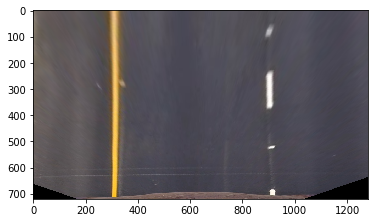

In [537]:
plt.imshow(test_images_warped[0])

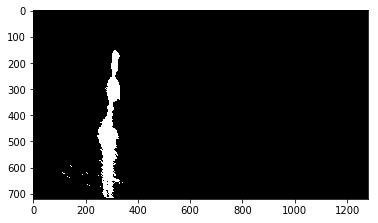

In [532]:
imgYellow = cv2.cvtColor(test_images_warped[6], cv2.COLOR_RGB2YCrCb)
lower_ycr = np.array([80,0,50])
upper_ycr = np.array([255,255,115])
saturationYellow = cv2.inRange(imgYellow, lower_ycr, upper_ycr)
plt.imshow(saturationYellow, cmap='gray')

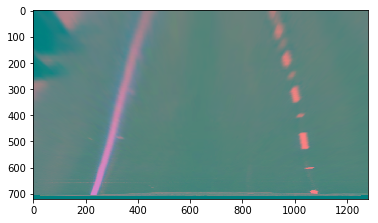

In [487]:
plt.imshow(imgYellow)

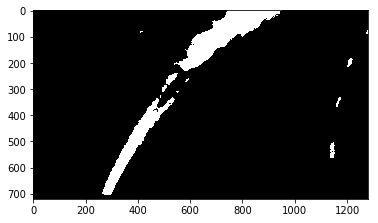

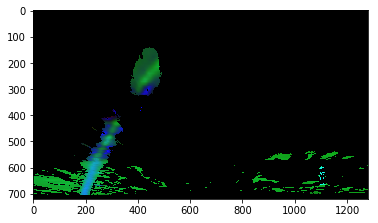

In [346]:
res = cv2.bitwise_and(imgYellow,imgYellow, mask= saturationYellow)
plt.imshow(res)